In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [2]:
file_extensions = [r"HotWater1.csv",r"HotWater2.csv",r"HotWater3.csv",r"HotWater4.csv",r"HotWater5.csv",r"HotWater6.csv",r"HotWater7.csv",r"HotWater8.csv",r"HotWater9.csv"]

In [3]:
# specify columns on which to train model
train_cols = ['hour__0', 'hour__1', 'hour__2',
       'hour__3', 'hour__4', 'hour__5', 'hour__6', 'hour__7', 'hour__8',
       'hour__9', 'hour__10', 'hour__11', 'hour__12', 'hour__13', 'hour__14',
       'hour__15', 'hour__16', 'hour__17', 'hour__18', 'hour__19', 'hour__20',
       'hour__21', 'hour__22', 'hour__23', 'weekday__0', 'weekday__1',
       'weekday__2', 'weekday__3', 'weekday__4', 'weekday__5', 'weekday__6', 'holiday', 'rm_1d_norm']
train_cols_4h = ['hour__0', 'hour__4', 'hour__8', 'hour__12', 'hour__16', 'hour__20', 'weekday__0', 'weekday__1',
       'weekday__2', 'weekday__3', 'weekday__4', 'weekday__5', 'weekday__6', 'holiday', 'rm_1d_norm']
train_cols_8h = ['hour__0', 'hour__8', 'hour__16', 'weekday__0', 'weekday__1',
       'weekday__2', 'weekday__3', 'weekday__4', 'weekday__5', 'weekday__6', 'holiday', 'rm_1d_norm']
target_col = "phi"


In [24]:
files_desc = ["Familie mit 1 Kind, beide mit Arbeit", "Single mit Arbeit", "2 Rentner, keine Arbeit", "WG 3 Studenten", "Junges Paar, keine Arbeit", "Schichtarbeiter-Paar", "Familie mit 3 Kindern, eine Person mit Arbeit, eine Person ohne Arbeit", "Multigenerationenhaushalt 2 mit Arbeit, 2 Kinder, 2 Senioren ohne Arbeit", "Arbeitsloser"]

In [4]:
def read_clean_files(file_endings, resample_freq):
    #load weather data
    w = pd.read_csv(r"/Users/ciro/OneDrive - ZHAW/3_HS18/Semesterarbeit/dhw_forecast-master/data/meteo/meteonorm-Bern-2015.csv", delimiter=";")
    w.columns = ["t_h", "gh", "dh", "sun_az", "hs", "v_air", "t_amb"]
    w["date"] = pd.to_datetime(w["t_h"], unit="h", origin="2015-01-01 00:00:00")
    w = w.set_index("date")
    if resample_freq > 1:
        w = w.resample(rule = str(resample_freq)+"h").last()
    df_dict = {}
    # load load profile data
    for i in file_endings:
        path = r"/Users/ciro/OneDrive - ZHAW/3_HS18/Semesterarbeit/dhw_forecast-master/data/dhw_profiles/SumProfiles." + i
        lp = pd.read_csv(path, delimiter=";")
        lp.columns = ["t_min", "phi"]
        lp["date"] = pd.to_datetime(lp["t_min"], unit="m", origin="2015-01-01 00:00:00")
        lp = lp.set_index("date")
        lp = lp.resample(rule = str(resample_freq)+"h").sum()
        lp.drop(lp[["t_min"]], axis=1, inplace=True)
        # merge dataframes on index
        df_combined = w.join(lp, how="inner")
        df_combined = df_combined[["t_amb","phi"]]
        # add date columns
        # add month (extract from date column)
        df_combined["month"] = df_combined.index.month
        #add weekday with Monday=0, Sunday=6(extract from date column)
        df_combined["weekday"] = df_combined.index.weekday
        # add hour (extract from date column)
        df_combined["hour"] = df_combined.index.hour
        # rename certain column to make their content clearer
        df_combined = df_combined.rename(columns = {"t_amb":"temp_amb"})
        # as a possible proxy for the current intensity of the water consumption a rolling mean for a set of periods is computed (1 period = 1h)
        # periods = 25 (=1day)
        df_combined["rm_1d"] = df_combined["phi"].rolling(window=int(25/resample_freq)).max()
        # set value for days where consumption = 0
        ttt = (df_combined["phi"].resample(rule="d").sum() == 0)[(df_combined["phi"].resample(rule="d").sum() == 0)].index.strftime("%Y-%m-%d").values
        for tt in ttt:
            df_combined.loc[tt,"holiday"] = 100
        df_combined["holiday"]=df_combined["holiday"].fillna(0)   
        # normalise rm_1d values and temp_amb columns to prevent model from being biased by large values
        df_combined["rm_1d_norm"] = (df_combined["rm_1d"] - df_combined["rm_1d"].mean()) / df_combined["rm_1d"].std()
        df_combined["temp_amb"] = (df_combined["temp_amb"] - df_combined["temp_amb"].mean()) / df_combined["temp_amb"].std()
        # create season attribute
        df_combined.loc[(df_combined.index >= "2015-12-22")|(df_combined.index <= "2015-03-20"), "season"] = "winter"
        df_combined.loc[(df_combined.index >= "2015-03-20")&(df_combined.index <= "2015-06-21"),"season"] = "spring"
        df_combined.loc[(df_combined.index >= "2015-06-21")&(df_combined.index <= "2015-09-23"), "season"] = "summer"
        df_combined.loc[(df_combined.index >= "2015-09-23")&(df_combined.index <= "2015-12-22"), "season"] = "autumn"
        # create dummy columns for hour, weekday and season
        df_combined = pd.get_dummies(df_combined, columns=["hour", "weekday", "season"], prefix=["hour_", "weekday_", "season_"])
        # drop rows with nan
        df_combined = df_combined.dropna()
        df_dict[i] = df_combined
    return df_dict

In [18]:
all_dfs = read_clean_files(file_extensions, 8)

In [19]:
# run knn model and add each rmse to dict
def run_knn(df_dict):
    rmse_dict = {}
    knn = KNeighborsRegressor(n_neighbors = 5)
    kf = KFold(n_splits = 24, shuffle=False, random_state=0)
    for f in file_extensions:
        mses = cross_val_score(knn, df_dict[f][train_cols_8h], df_dict[f][target_col], scoring="neg_mean_squared_error", cv=kf)
        rmses = np.sqrt(np.absolute(mses))
        avg_rmse = np.mean(rmses)
        rmse_dict[f] = avg_rmse
    return rmse_dict

In [7]:
results = {}

In [20]:
rmses = run_knn(all_dfs)

In [21]:
results["rmse_8h_forecast"] = rmses

In [22]:
results_df = pd.DataFrame(results)

In [71]:
results_df.index = files_desc
results_df = results_df.sort_index()
results_df = results_df.round(decimals=2)
results_df

,rmse_1h_forecast,rmse_4h_forecast,rmse_8h_forecast
"2 Rentner, keine Arbeit",10.08,19.16,23.81
Arbeitsloser,9.56,13.86,19.17
"Familie mit 1 Kind, beide mit Arbeit",10.37,16.50,21.69
"Familie mit 3 Kindern, eine Person mit Arbeit, eine Person ohne Arbeit",16.56,24.19,28.14
"Junges Paar, keine Arbeit",8.30,10.72,14.68
"Multigenerationenhaushalt 2 mit Arbeit, 2 Kinder, 2 Senioren ohne Arbeit",8.49,14.90,17.92
Schichtarbeiter-Paar,6.80,9.48,12.33
Single mit Arbeit,13.06,21.87,28.60
WG 3 Studenten,11.00,19.51,25.67


In [72]:
results_df.to_csv(r"/Users/ciro/OneDrive - ZHAW/3_HS18/Semesterarbeit/results_all.csv", index=True)

In [33]:
df_5 = all_dfs["HotWater5.csv"]

In [35]:
train_5 = df_5[(df_5.month <= 11)]
test_5 = df_5[(df_5.month > 11)]

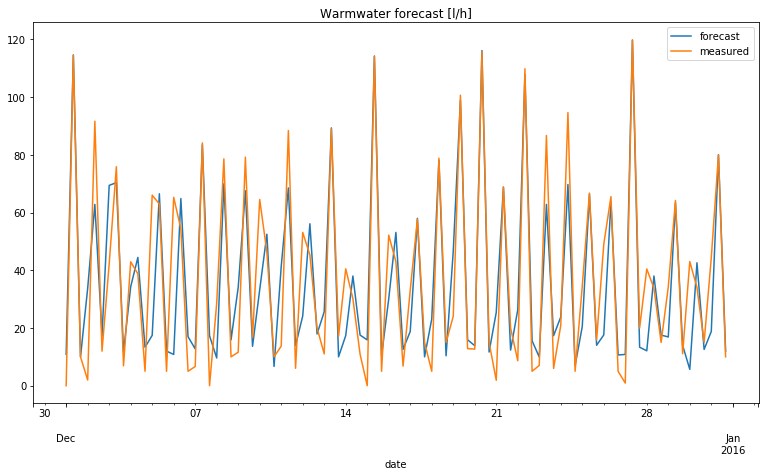

In [69]:
knn = KNeighborsRegressor(n_neighbors = 3)
knn.fit(train_5[train_cols_8h], train_5[target_col])
predictions = pd.DataFrame(knn.predict(test_5[train_cols_8h]))
predictions.index = test_5[target_col].index
compare_df = predictions.join(test_5[target_col], how="inner")
compare_df.columns = ["forecast", "measured"]
compare_df.plot(title="Warmwater forecast [l/h]", figsize=(13,7))